## Import the libraries

In [1]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
os.listdir('../data')

['bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'four',
 'go',
 'happy',
 'house',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'wow',
 'yes',
 'zero']

## Visualization of Audio signal in time series domain
### wav plotting using Matplotlib

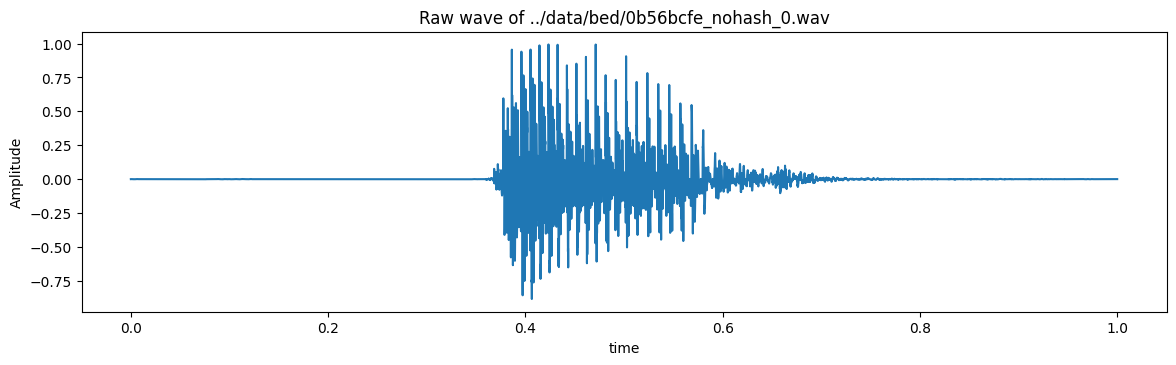

In [4]:
train_audio_path = '../data/'
samples, sample_rate = librosa.load(train_audio_path+'bed/0b56bcfe_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + '../data/bed/0b56bcfe_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

## Sampling rate


In [5]:
ipd.Audio(samples, rate=sample_rate)
print(sample_rate)

16000


## Resampling

In [6]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

In [7]:
labels=os.listdir(train_audio_path)

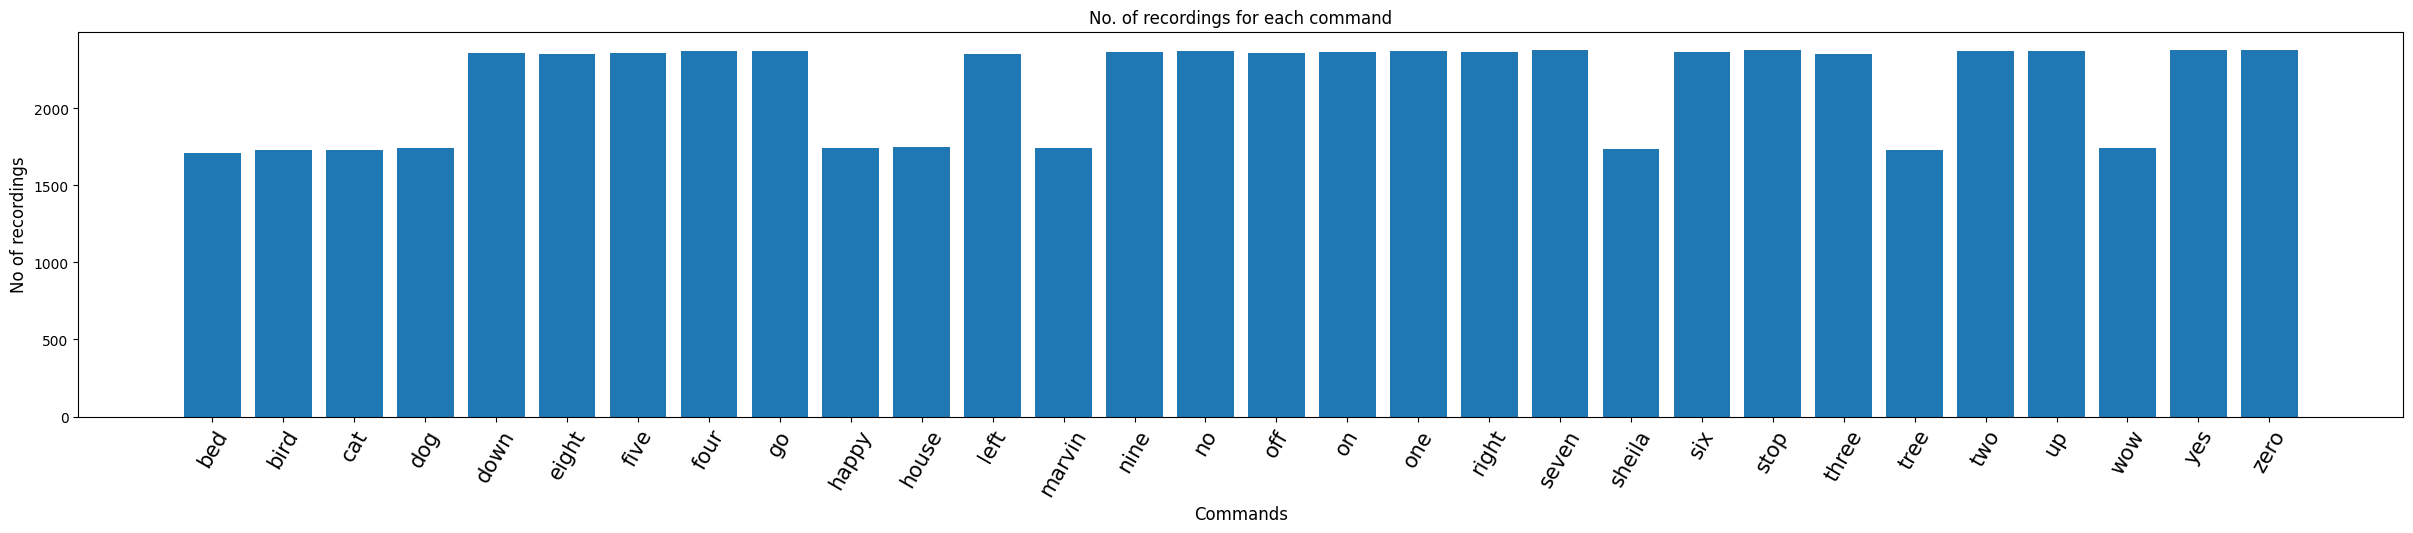

In [8]:
#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))

#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

In [10]:
labels=["bed","bird", "cat","dog", "down","eight","five","four","go","happy","house","left","marvin","nine","no","off","on","one","right","seven","sheila","six","stop","three","tree","two","up","wow","yes","zero"]



## Duration of recordings

(array([1.200e+01, 2.000e+01, 1.800e+02, 1.590e+02, 3.760e+02, 6.480e+02,
        9.670e+02, 8.000e+02, 1.419e+03, 6.014e+04]),
 array([0.3715625 , 0.43440625, 0.49725   , 0.56009375, 0.6229375 ,
        0.68578125, 0.748625  , 0.81146875, 0.8743125 , 0.93715625,
        1.        ]),
 <BarContainer object of 10 artists>)

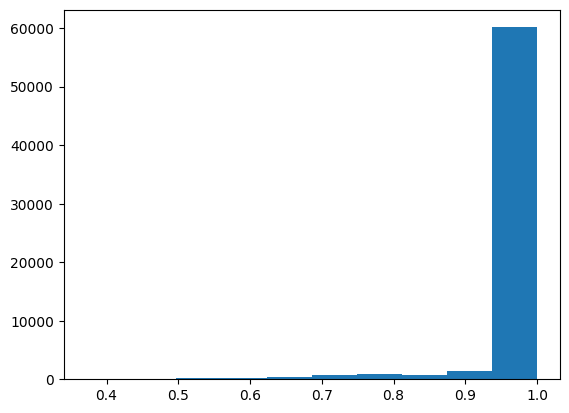

In [9]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))

plt.hist(np.array(duration_of_recordings))

## Preprocessing the audio waves

In [10]:
#train_audio_path = '../data/'

all_wave = []
all_label = []
for label in labels:
    print('loading ' + label + ' files')
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) :
            all_wave.append(samples)
            all_label.append(label)
    print('successfully loaded all ' + label + ' files')

loading bed files
successfully loaded all bed files
loading bird files
successfully loaded all bird files
loading cat files
successfully loaded all cat files
loading dog files
successfully loaded all dog files
loading down files
successfully loaded all down files
loading eight files
successfully loaded all eight files
loading five files
successfully loaded all five files
loading four files
successfully loaded all four files
loading go files
successfully loaded all go files
loading happy files
successfully loaded all happy files
loading house files
successfully loaded all house files
loading left files
successfully loaded all left files
loading marvin files
successfully loaded all marvin files
loading nine files
successfully loaded all nine files
loading no files
successfully loaded all no files
loading off files
successfully loaded all off files
loading on files
successfully loaded all on files
loading one files
successfully loaded all one files
loading right files
successfully loaded 

### Convert the output labels to integer encoded:

In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

In [12]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

### Reshape the 2D array to 3D since the input to the conv1d must be a 3D array:

In [13]:
all_wave = np.array(all_wave).reshape(-1,8000,1)


## Split into train and validation set
### Next, we will train the model on 80% of the data and validate on the remaining 20%:

In [14]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

## Model Architecture for this problem
### We will build the speech-to-text model using conv1d. Conv1d is a convolutional neural network which performs the convolution along only one dimension.

## Model building
### Let us implement the model using Keras functional API.

In [15]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

In [16]:
K.clear_session()
inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)
#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 7988, 8)           112       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2662, 8)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2662, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2652, 16)          1424      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 884, 16)          0         
 1D)                                                         

### Define the loss function to be categorical cross-entropy since it is a multi-classification problem:

In [17]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

### Early stopping and model checkpoints are the callbacks to stop training the neural network at the right time and to save the best model after every epoch:

In [18]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001)
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

### Let us train the model on a batch size of 32 and evaluate the performance on the holdout set:

In [33]:
history=model.fit(x_tr, y_tr ,epochs=15, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Epoch 1/15
1457/1457 [==============================] - 252s 173ms/step - loss: 1.1566 - accuracy: 0.6460 - val_loss: 1.0413 - val_accuracy: 0.6821
Epoch 2/15
1457/1457 [==============================] - 255s 175ms/step - loss: 1.0893 - accuracy: 0.6672 - val_loss: 0.9201 - val_accuracy: 0.7356
Epoch 3/15
1457/1457 [==============================] - 281s 193ms/step - loss: 1.0400 - accuracy: 0.6826 - val_loss: 0.9026 - val_accuracy: 0.7399
Epoch 4/15
1457/1457 [==============================] - 264s 181ms/step - loss: 1.0031 - accuracy: 0.6938 - val_loss: 0.8344 - val_accuracy: 0.7577
Epoch 5/15
1457/1457 [==============================] - 255s 175ms/step - loss: 0.9575 - accuracy: 0.7071 - val_loss: 0.8221 - val_accuracy: 0.7584
Epoch 6/15
1457/1457 [==============================] - 285s 196ms/step - loss: 0.9372 - accuracy: 0.7136 - val_loss: 0.7889 - val_accuracy: 0.7695
Epoch 7/15
1457/1457 [==============================] - 309s 212ms/step - loss: 0.8990 - accuracy: 0.7242 - val_

## Diagnostic plot
### I’m going to lean on visualization again to understand the performance of the model over a period of time:

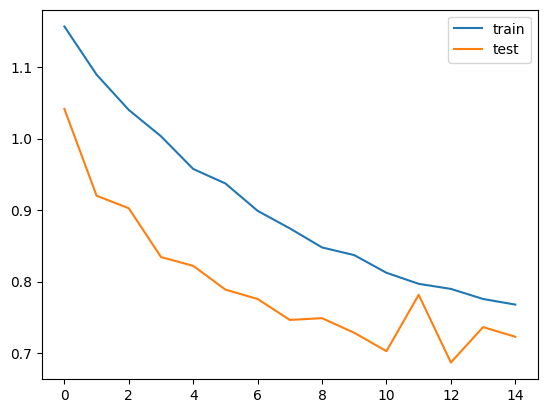

In [34]:

from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()





## save  the best model

In [35]:
model.save('best_model1.hdf5')

## predicts text for the given audio:

In [36]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [40]:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

Audio: left


### The best part is yet to come! Here is a script that prompts a user to record voice commands. Record your own voice commands and test it on the model:

### yes i have now own speech-to-text model!